# BREEDS dataset creation overview

In [1]:
data_dir = '/tmp/imagenet'
info_dir = './imagenet_class_hierarchy/modified'
num_workers = 10
batch_size = 10

In [2]:
import os
from robustness.tools.breeds_helpers import setup_breeds

if not (os.path.exists(info_dir) and len(os.listdir(info_dir))):
    print("Downloading class hierarchy information into `info_dir`")
    setup_breeds(info_dir)

## Browsing through the class hierarchy

In [3]:
from robustness.tools.breeds_helpers import ClassHierarchy
import numpy as np
hier = ClassHierarchy(info_dir)
print(f"# Levels in the hierarchy: {np.max(list(hier.level_to_nodes.keys()))}")
print(f"# Nodes/level:",
  [f"Level {k}: {len(v)}" for k, v in hier.level_to_nodes.items()])

# Levels in the hierarchy: 8
# Nodes/level: ['Level 0: 1', 'Level 1: 2', 'Level 2: 10', 'Level 3: 29', 'Level 4: 128', 'Level 5: 466', 'Level 6: 591', 'Level 7: 98', 'Level 8: 3']


### Defining superclasses

In [4]:
level = 2 # Could be any number smaller than max level
superclasses = hier.get_nodes_at_level(level)
print(f"Superclasses at level {level}:\n")
print(", ".join([f"({si}: {hier.HIER_NODE_NAME[s]})" for si, s in enumerate(superclasses)]))

Superclasses at level 2:

(0: plant, flora, plant life), (1: person), (2: structure, place), (3: fungus), (4: furnishing), (5: conveyance, transport), (6: paraphernalia), (7: food, nutrient), (8: apparel, toiletries), (9: animal, animate being, beast, brute, creature, fauna)


### Inspecting the Subclasses ("breeds") of a specific superclass

In [5]:
idx = np.random.randint(0, len(superclasses), 1)[0]
superclass = list(superclasses)[idx]
subclasses = hier.leaves_reachable(superclass)
print(f"Superclass: {hier.HIER_NODE_NAME[superclass]}\n")

print(f"Subclasses ({len(subclasses)}):")
print([f"{hier.LEAF_ID_TO_NAME[l]}" for l in list(subclasses)])

Superclass: fungus

Subclasses (7):
['coral fungus', 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa', 'earthstar', 'gyromitra', 'stinkhorn, carrion fungus', 'bolete', 'agaric']


### Visualizing a sub-tree (can be slow for large trees)

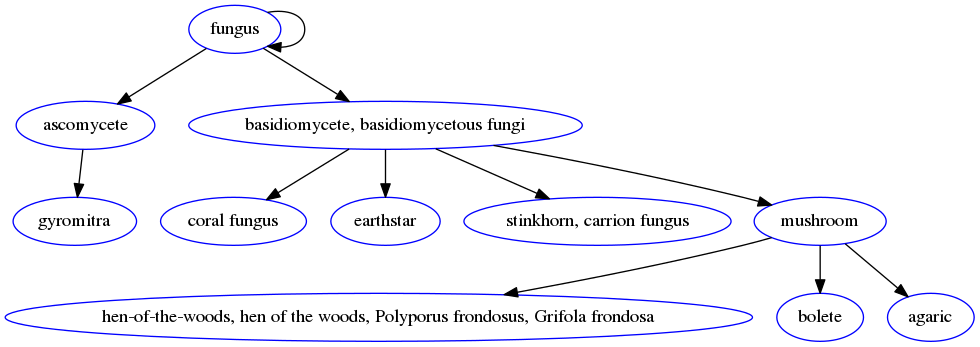

In [6]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
from IPython.display import Image

subtree = nx.ego_graph(hier.graph, superclass, radius=10)
mapping = {n: hier.HIER_NODE_NAME[n] for n in subtree.nodes()}
subtree = to_agraph(nx.relabel_nodes(subtree, mapping))
subtree.layout('dot')
subtree.node_attr['color']='blue'
subtree.draw('graph.png', format='png')
Image('graph.png')

## Creating BREEDS datasets

In [7]:
from robustness.tools.breeds_helpers import BreedsDatasetGenerator
DG = BreedsDatasetGenerator(info_dir)

### Example: Balanced dataset from level=2 with subclasses partitioned randomly

In [8]:
ret = DG.get_superclasses(level=2, 
                      Nsubclasses=None, 
                      split="rand", 
                      ancestor=None, 
                      balanced=True)
superclasses, subclass_split, label_map = ret 

### Take a closer look at the dataset and subpopulations involved

In [9]:
from robustness.tools.breeds_helpers import print_dataset_info

print_dataset_info(superclasses, 
                   subclass_split, 
                   label_map, 
                   hier.LEAF_NUM_TO_NAME)

,superclass,subclasses (source),subclasses (target)
0,fungus,[earthstar (995)],[agaric (992)]
1,"structure, place",[megalith (649)],[lumbermill (634)]
2,paraphernalia,[golf ball (574)],[sewing machine (786)]
3,person,[groom (982)],[ballplayer (981)]
4,"animal, animate being, beast, brute, creature,...",[box turtle (37)],[common iguana (39)]
5,"plant, flora, plant life",[yellow lady's slipper (986)],[daisy (985)]
6,"food, nutrient",[ice lolly (929)],[cardoon (946)]
7,"apparel, toiletries",[clog (502)],[knee pad (615)]
8,"conveyance, transport",[racer (751)],[tractor (866)]
9,furnishing,[barber chair (423)],[dining table (532)]


### Create PyTorch dataset and loaders

In [10]:
from robustness import datasets
train_subclasses, test_subclasses = subclass_split

dataset_source = datasets.CustomImageNet(data_dir, train_subclasses)
loaders_source = dataset_source.make_loaders(num_workers, batch_size)
train_loader_source, val_loader_source = loaders_source

dataset_target = datasets.CustomImageNet(data_dir, test_subclasses)
loaders_target = dataset_source.make_loaders(num_workers, batch_size)
train_loader_target, val_loader_target = loaders_target

==> Preparing dataset custom_imagenet..
==> Preparing dataset custom_imagenet..


### Visualize dataset samples

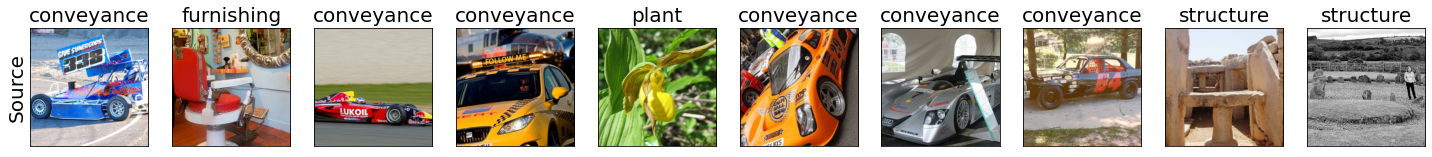

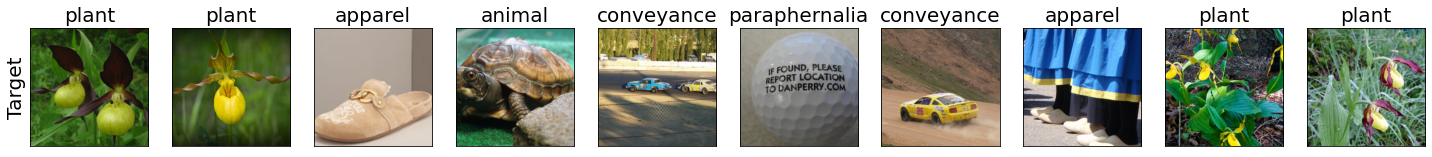

In [11]:
from robustness.tools.vis_tools import show_image_row
import matplotlib
%matplotlib inline 

for domain, loader in zip(["Source", "Target"],
                        [val_loader_source, val_loader_target]):
    im, lab = next(iter(loader))
    show_image_row([im], 
                 tlist=[[label_map[int(k)].split(",")[0] for k in lab]],
                 ylist=[domain],
                 fontsize=20)

### Superclass datasets without partitioning

In [12]:
ret = DG.get_superclasses(level=2, 
                          Nsubclasses=2, 
                          split=None, 
                          ancestor=None, 
                          balanced=True)
superclasses, subclass_split, label_map = ret
all_subclasses = subclass_split[0]

dataset = datasets.CustomImageNet(data_dir, all_subclasses)

print_dataset_info(superclasses,
                   subclass_split, 
                   label_map, 
                   hier.LEAF_NUM_TO_NAME)

,superclass,subclasses
0,fungus,"[earthstar (995), agaric (992)]"
1,"structure, place","[megalith (649), lumbermill (634)]"
2,paraphernalia,"[golf ball (574), sewing machine (786)]"
3,person,"[groom (982), ballplayer (981)]"
4,"animal, animate being, beast, brute, creature,...","[box turtle (37), common iguana (39)]"
5,"plant, flora, plant life","[yellow lady's slipper (986), daisy (985)]"
6,"food, nutrient","[ice lolly (929), cardoon (946)]"
7,"apparel, toiletries","[clog (502), knee pad (615)]"
8,"conveyance, transport","[racer (751), tractor (866)]"
9,furnishing,"[barber chair (423), dining table (532)]"


## Loading in-built BREEDS datasets

In [13]:
from robustness.tools.breeds_helpers import make_living17
ret = make_living17(info_dir, split="rand")
superclasses, subclass_split, label_map = ret

print_dataset_info(superclasses, 
                   subclass_split,
                   label_map, 
                   hier.LEAF_NUM_TO_NAME)

,superclass,subclasses (source),subclasses (target)
0,salamander,"[eft (27), axolotl (29)]","[common newt (26), spotted salamander (28)]"
1,turtle,"[box turtle (37), leatherback turtle (34)]","[loggerhead (33), mud turtle (35)]"
2,lizard,"[whiptail (41), alligator lizard (44)]","[African chameleon (47), banded gecko (38)]"
3,"snake, serpent, ophidian","[night snake (60), garter snake (57)]","[sea snake (65), boa constrictor (61)]"
4,spider,"[tarantula (76), black and gold garden spider ...","[garden spider (74), wolf spider (77)]"
5,grouse,"[ptarmigan (81), prairie chicken (83)]","[ruffed grouse (82), black grouse (80)]"
6,parrot,"[macaw (88), lorikeet (90)]","[African grey (87), sulphur-crested cockatoo (..."
7,crab,"[Dungeness crab (118), fiddler crab (120)]","[rock crab (119), king crab (121)]"
8,"dog, domestic dog, Canis familiaris","[bloodhound (163), Pekinese (154)]","[Great Pyrenees (257), papillon (157)]"
9,wolf,"[coyote (272), red wolf (271)]","[white wolf (270), timber wolf (269)]"
